In [13]:
import os
import json
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [56]:
df = pd.read_csv('./model-recovery-timestep-incomplete-fit_df.csv')
df.head()

,Unnamed: 0,lightcurve,true_model,lightcurve_path,true_params,true_lightcurve,fit_model,fit_path,t_max,residual,log_likelihood,log_prior,log_bayes_factor,best_fit_params,best_fit_lightcurve
0,0,Bu2019lm_00000,Bu2019lm,./model-recovery-injections/lc_Bu2019lm_00000....,"{'simulation_id': 0, 'luminosity_distance': 9....","{'sample_times': {0: 0.1, 1: 0.6, 2: 1.1, 3: 1...",Bu2019lm,/expanse/lustre/projects/umn131/tbarna/model-r...,4.0,31.863936,-0.920648,-9.724034,-4.432040,"{'luminosity_distance': 1.0552711497615537, 'K...","{'ztfg': {0: 13.17343551787389, 1: 9.475609104..."
1,1,Bu2019lm_00000,Bu2019lm,./model-recovery-injections/lc_Bu2019lm_00000....,"{'simulation_id': 0, 'luminosity_distance': 9....","{'sample_times': {0: 0.1, 1: 0.6, 2: 1.1, 3: 1...",Piro2021,/expanse/lustre/projects/umn131/tbarna/model-r...,4.0,45.755245,-0.920648,-12.429216,-7.605451,"{'luminosity_distance': 4.10793462786149, 'tim...","{'ztfg': {0: 12.942305431026519, 1: 11.1719891..."
2,2,Bu2019lm_00000,Bu2019lm,./model-recovery-injections/lc_Bu2019lm_00000....,"{'simulation_id': 0, 'luminosity_distance': 9....","{'sample_times': {0: 0.1, 1: 0.6, 2: 1.1, 3: 1...",TrPi2018,/expanse/lustre/projects/umn131/tbarna/model-r...,4.0,178.062287,-0.920648,-10.899006,-5.201067,"{'luminosity_distance': 173.3132469926188, 'ti...","{'ztfg': {0: 9.624843476737759, 1: 9.669453095..."
3,3,Bu2019lm_00000,Bu2019lm,./model-recovery-injections/lc_Bu2019lm_00000....,"{'simulation_id': 0, 'luminosity_distance': 9....","{'sample_times': {0: 0.1, 1: 0.6, 2: 1.1, 3: 1...",nugent-hyper,/expanse/lustre/projects/umn131/tbarna/model-r...,4.0,8.851694,-1.151926,-7.313220,-4.495743,"{'luminosity_distance': 150.0171065044189, 'ti...","{'ztfg': {0: 16.398983138937325, 1: 14.4536050..."
4,4,Bu2019lm_00000,Bu2019lm,./model-recovery-injections/lc_Bu2019lm_00000....,"{'simulation_id': 0, 'luminosity_distance': 9....","{'sample_times': {0: 0.1, 1: 0.6, 2: 1.1, 3: 1...",Bu2019lm,/expanse/lustre/projects/umn131/tbarna/model-r...,5.0,22.596165,-2.760769,-10.538364,-7.344385,"{'luminosity_distance': 1.2662135362625122, 'K...","{'ztfg': {0: 13.275306947438292, 1: 9.63701330..."


,t_max,fit_model,true_model,log_bayes_factor
0,3.0,Bu2019lm,Bu2019lm,-7.332176
1,3.0,Bu2019lm,Piro2021,-16.386851
2,3.0,Bu2019lm,TrPi2018,-12.009964
3,3.0,Bu2019lm,nugent-hyper,-17.239357
4,3.0,Piro2021,Bu2019lm,-13.122054
...,...,...,...,...
123,10.0,TrPi2018,nugent-hyper,-31.337622
124,10.0,nugent-hyper,Bu2019lm,-90.577948
125,10.0,nugent-hyper,Piro2021,-11.680468
126,10.0,nugent-hyper,TrPi2018,-41.339878


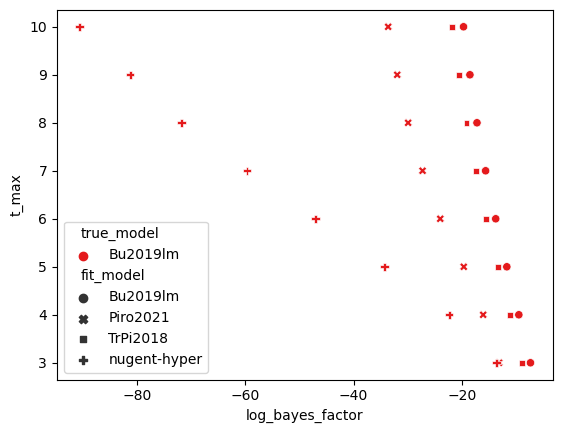

[0. 0. 0. 0. 0. 0. 0. 0.]
[ -5.78987728  -6.58319402  -7.94962895 -10.24002436 -11.64137778
 -12.71293168 -13.42381708 -13.91372959]
[-1.49612326 -1.58625472 -1.68921149 -1.71643978 -1.7946566  -1.93146691
 -2.00829951 -2.11899626]
[ -6.26919604 -12.83940338 -22.58980781 -33.26277262 -44.04597256
 -54.52501819 -62.73169188 -70.88364495]


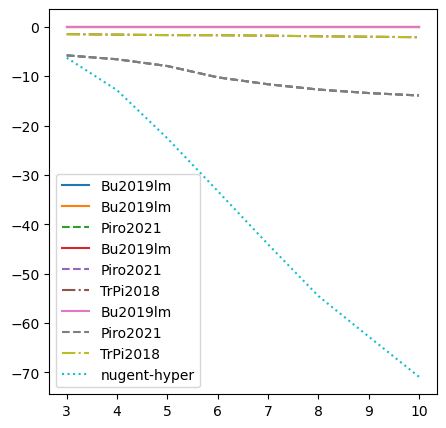

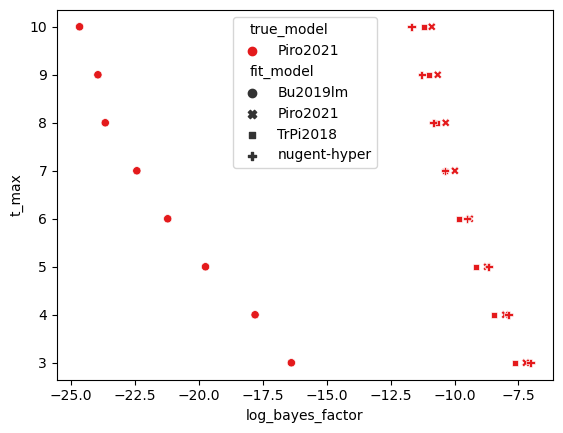

[ -9.17879893  -9.78955393 -11.0180689  -11.82605203 -12.44861047
 -13.32419192 -13.30028729 -13.78468491]
[0. 0. 0. 0. 0. 0. 0. 0.]
[-0.42778144 -0.44423535 -0.44421063 -0.4197587  -0.37216339 -0.35772067
 -0.34980442 -0.31914245]
[ 0.17983766  0.13289917  0.06820247 -0.1138442  -0.38332795 -0.48918819
 -0.62586855 -0.78879458]


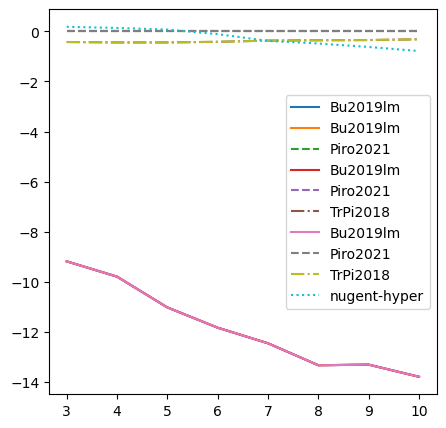

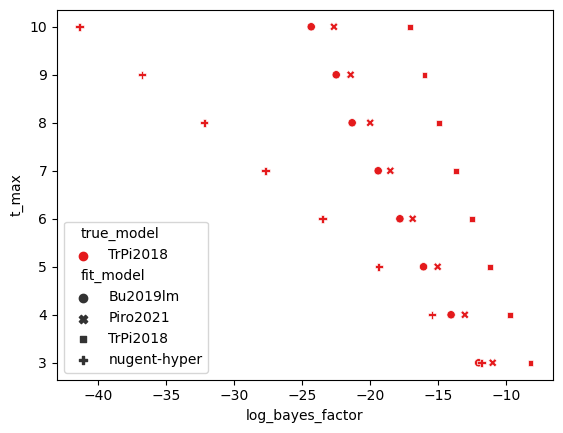

[-3.8093057  -4.29823223 -4.90207379 -5.31693566 -5.68793198 -6.41441266
 -6.48808628 -7.23697551]
[-2.77688213 -3.28825264 -3.86268768 -4.37748784 -4.79494453 -5.09062904
 -5.42807281 -5.56727976]
[0. 0. 0. 0. 0. 0. 0. 0.]
[ -3.58892805  -5.69932465  -8.19664467 -10.99466575 -13.97206941
 -17.28086828 -20.75842111 -24.2618749 ]


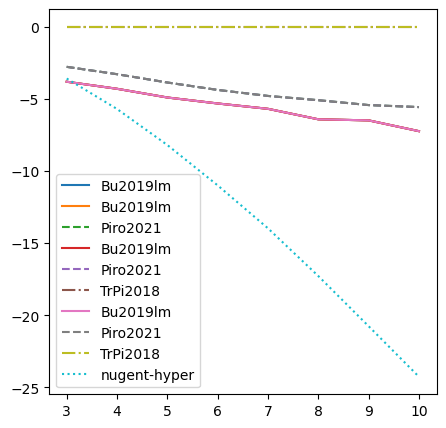

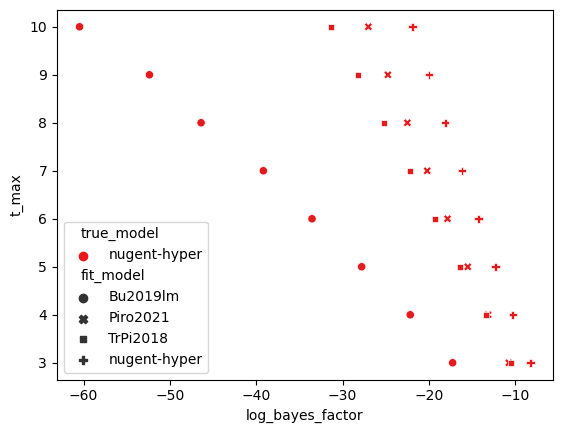

[ -9.02144507 -11.88135234 -15.52042698 -19.30342436 -23.00592305
 -28.30192837 -32.38674444 -38.57238912]
[-2.50533708 -2.86432535 -3.23256226 -3.6068851  -4.02234384 -4.39645404
 -4.75637657 -5.10816786]
[-2.28526405 -3.13408445 -4.09251837 -5.07243864 -6.05933    -7.10629377
 -8.18885354 -9.44288206]
[0. 0. 0. 0. 0. 0. 0. 0.]


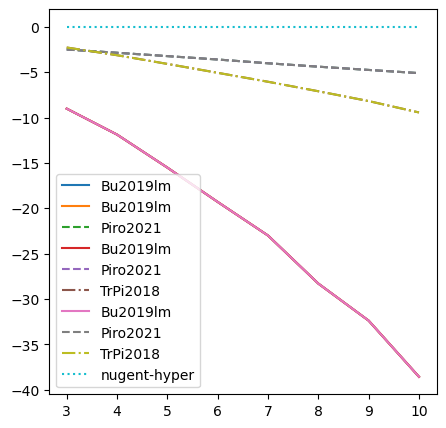

In [82]:
grouped_df = df.groupby(['t_max', 'fit_model', 'true_model']).agg({'log_bayes_factor': 'mean'}).reset_index()
display(grouped_df)
## dictionary of linestyles for each model (models are found in fit_model column)
ls_dict = {model:value for model, value in zip(grouped_df['fit_model'].unique(), ['-', '--', '-.', ':'])}

for model in grouped_df['true_model'].unique():
    iter_df = grouped_df[grouped_df['true_model']==model]
    sns.scatterplot(data=iter_df, x='log_bayes_factor', y='t_max', hue='true_model', style='fit_model', palette='Set1')
    plt.show()
    
    ## additional plot that shows the difference between the true_model log_bayes_factor and the other model log_bayes factors for each t_max. x-axis is t_max, y-axis is log_bayes_factor difference
    ## this plot should be a line plot with a line for each model
    log_bayes_factor_diff = {}
    fig, ax = plt.subplots(figsize=(5,5))
    for fit_model in iter_df['fit_model'].unique():
        fit_model_df = iter_df[iter_df['fit_model']==fit_model]

        log_bayes_factor_diff[fit_model] = fit_model_df['log_bayes_factor'].values - iter_df[iter_df['fit_model']==model]['log_bayes_factor'].values
        print(log_bayes_factor_diff[fit_model])
        for fit in iter_df['fit_model'].unique():
            try:
                ax.plot(fit_model_df['t_max'], log_bayes_factor_diff[fit], label=fit, linestyle=ls_dict[fit])
            except:
                pass 
    ax.legend()
    plt.show()
        # [sns.lineplot(data=fit_model_df, x='t_max', y=log_bayes_factor_diff[fit_model], hue='fit_model', palette='Set1') for fit_model in iter_df['fit_model'].unique()]

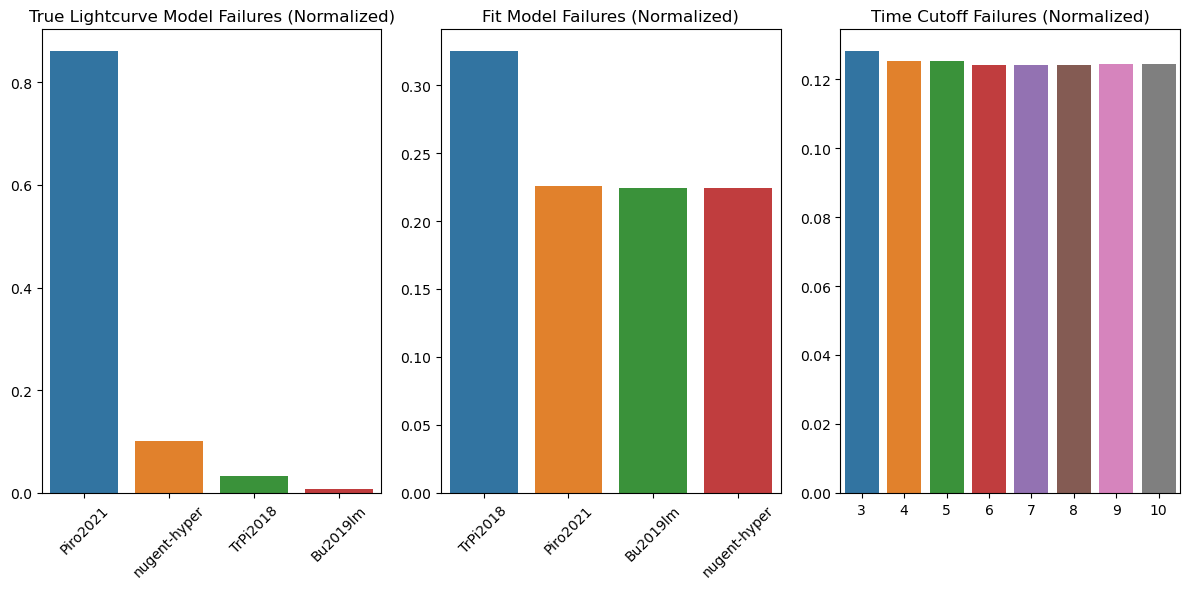

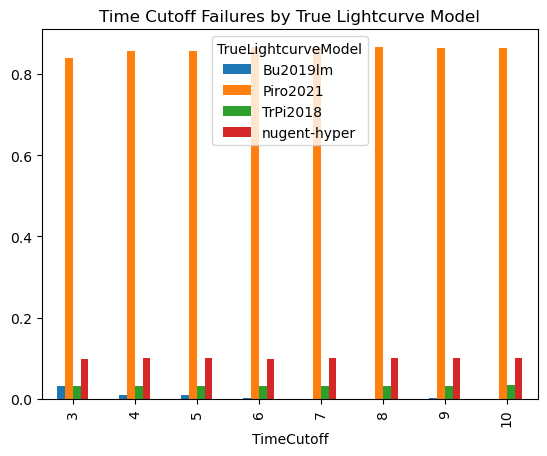

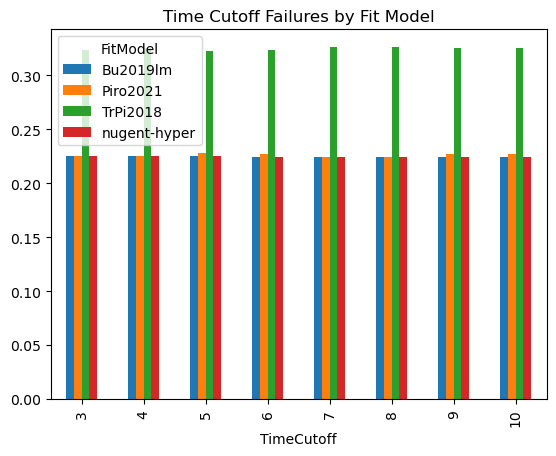

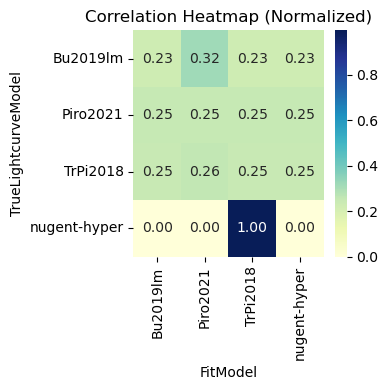

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the text file into a DataFrame
file_path = "model-recovery-failures.txt"  # Replace with the actual file path
with open(file_path, 'r') as file:
    lines = file.readlines()

# Parse the data from file names and create a DataFrame
data = []
for line in lines:
    parts = line.strip().split('/')
    filename = parts[-1]
    model_parts = filename.split('_')
    true_lightcurve_model = model_parts[1]
    unique_identifier = model_parts[2]
    fit_model = model_parts[4]
    time_cutoff = int(model_parts[-1].split('_tmax_')[-1].split('.')[0])
    data.append([true_lightcurve_model, unique_identifier, fit_model, time_cutoff])

df = pd.DataFrame(data, columns=['TrueLightcurveModel', 'UniqueIdentifier', 'FitModel', 'TimeCutoff'])

# Calculate statistics and normalize
total_entries = len(df)

true_lightcurve_failures = df['TrueLightcurveModel'].value_counts(normalize=True)
fit_model_failures = df['FitModel'].value_counts(normalize=True)
time_cutoff_failures = df['TimeCutoff'].value_counts(normalize=True)

# Create a heatmap to explore correlations between true lightcurve models and fit models
heatmap_data = df.groupby(['TrueLightcurveModel', 'FitModel']).size().unstack().fillna(0).apply(lambda x: x / x.sum(), axis=1)
plt.figure(figsize=(12, 6))

plt.subplot(131)
sns.barplot(x=true_lightcurve_failures.index, y=true_lightcurve_failures.values)
plt.title('True Lightcurve Model Failures (Normalized)')
plt.xticks(rotation=45)

plt.subplot(132)
sns.barplot(x=fit_model_failures.index, y=fit_model_failures.values)
plt.title('Fit Model Failures (Normalized)')
plt.xticks(rotation=45)

plt.subplot(133)
sns.barplot(x=time_cutoff_failures.index, y=time_cutoff_failures.values)
plt.title('Time Cutoff Failures (Normalized)')
plt.tight_layout()
plt.show()

# Additional plots based on time cutoff failures
# plt.figure(figsize=(15, 6))

# # Plot based on the third value as True Lightcurve Model
# plt.subplot(121)
time_cutoff_by_true_lightcurve = df.groupby(['TimeCutoff', 'TrueLightcurveModel']).size().unstack().fillna(0).apply(lambda x: x / x.sum(), axis=1)
time_cutoff_by_true_lightcurve.plot(kind='bar', stacked=False)
plt.title('Time Cutoff Failures by True Lightcurve Model')
plt.show()

# Plot based on the third value as Fit Model
# plt.subplot(122)
time_cutoff_by_fit_model = df.groupby(['TimeCutoff', 'FitModel']).size().unstack().fillna(0).apply(lambda x: x / x.sum(), axis=1)
time_cutoff_by_fit_model.plot(kind='bar', stacked=False)
plt.title('Time Cutoff Failures by Fit Model')
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(141)
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Correlation Heatmap (Normalized)')

plt.tight_layout()
plt.show()


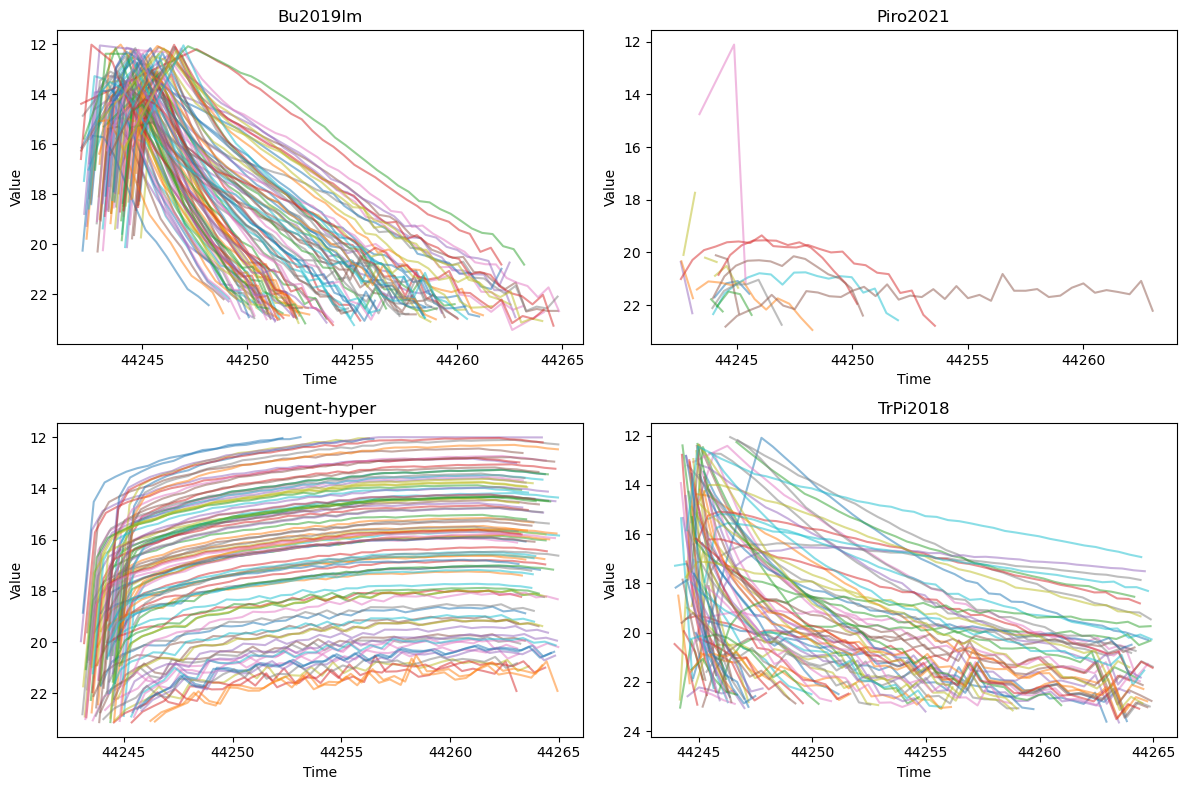

In [11]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

folder_path = 'model-recovery-injections'
model_data = {}

for filename in os.listdir(folder_path):
    if filename.startswith("lc_") and filename.endswith(".json"):
        model_name = filename.split("_")[1]
        with open(os.path.join(folder_path, filename), 'r') as file:
            data = json.load(file)
            ztfg_data = data.get("ztfg", [])

        if model_name not in model_data:
            model_data[model_name] = []
        model_data[model_name].append(ztfg_data)

plt.figure(figsize=(12, 8))

## Iterate through model data and plot each lightcurve as a separate line
num_plots = len(model_data)
rows = num_plots // 2 + num_plots % 2  ## Determine the number of rows for subplots
for i, (model_name, lc_list) in enumerate(model_data.items()):
    ax = plt.subplot(rows, 2, i + 1)
    [sns.lineplot(data=pd.DataFrame(lc_data, columns=["Time", "Value", "Uncertainty"]), x="Time", y="Value", alpha=0.5) 
     for lc_data in lc_list]
    plt.title(model_name)
    plt.xlabel("Time")
    plt.ylabel("Value")
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

In [18]:
## read in txt file defined by file_path
import numpy as np
file_path = "model-recovery-failures.txt"
lc_names = []
with open(file_path, 'r') as file:
    lines = file.readlines()
for line in lines:
    lc_name = line.split('/')[7]

    lc_names.append(lc_name)

orig_size = np.shape(lc_names)
print('count w/ dupes: ',orig_size)
## remove duplicates from lc_names
lc_names = list(set(lc_names))
new_size = np.shape(lc_names)
print ('count w/o dupes: ',new_size)
print('% removed: ',(orig_size[0]-new_size[0])/orig_size[0])

count w/ dupes:  (3014,)
count w/o dupes:  (129,)
% removed:  0.9571997345719974


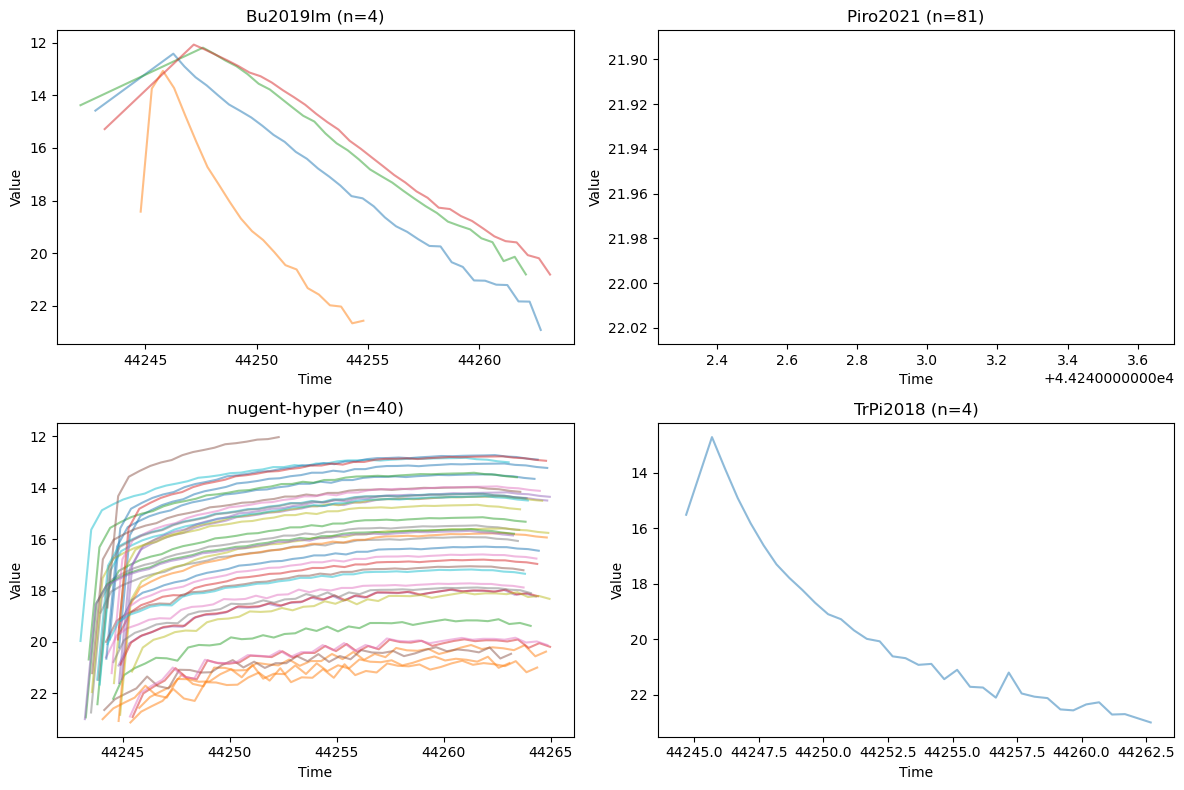

In [24]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

folder_path = 'model-recovery-injections'
model_data = {}
model_data_count = {}
for filename in os.listdir(folder_path):
    if filename.startswith("lc_") and filename.endswith(".json"):
        ## check if filename is in lc_names (account for filename ending with json)
        if filename.split('.')[0] not in lc_names:
            continue
        model_name = filename.split("_")[1]
        with open(os.path.join(folder_path, filename), 'r') as file:
            data = json.load(file)
            ztfg_data = data.get("ztfg", [])

        if model_name not in model_data:
            model_data[model_name] = []
            model_data_count[model_name] = 0
        model_data[model_name].append(ztfg_data)
        model_data_count[model_name] += 1

plt.figure(figsize=(12, 8))

## Iterate through model data and plot each lightcurve as a separate line
num_plots = len(model_data)
rows = num_plots // 2 + num_plots % 2  ## Determine the number of rows for subplots
for i, (model_name, lc_list) in enumerate(model_data.items()):
    ax = plt.subplot(rows, 2, i + 1)
    [sns.lineplot(data=pd.DataFrame(lc_data, columns=["Time", "Value", "Uncertainty"]), x="Time", y="Value", alpha=0.5) 
     for lc_data in lc_list]
    plt.title(f"{model_name} (n={model_data_count[model_name]})")
    plt.xlabel("Time")
    plt.ylabel("Value")
    ax.invert_yaxis()


plt.tight_layout()
plt.show()

Difference between Piro2021 injections when enforcing valid lightcurve generation

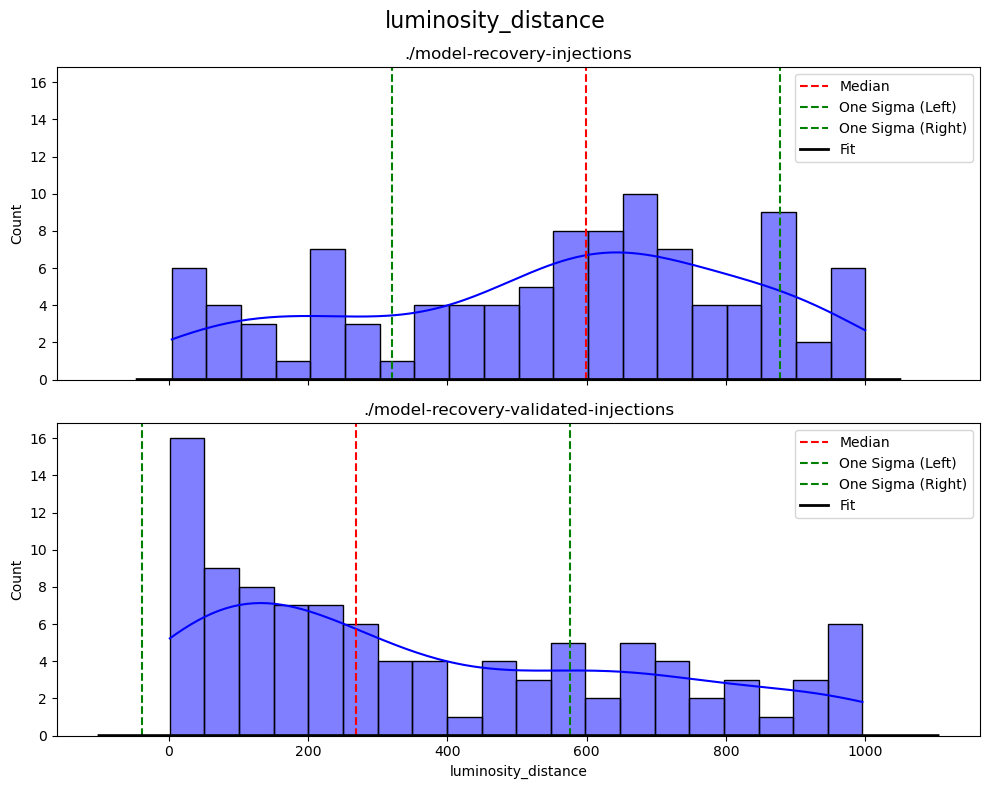

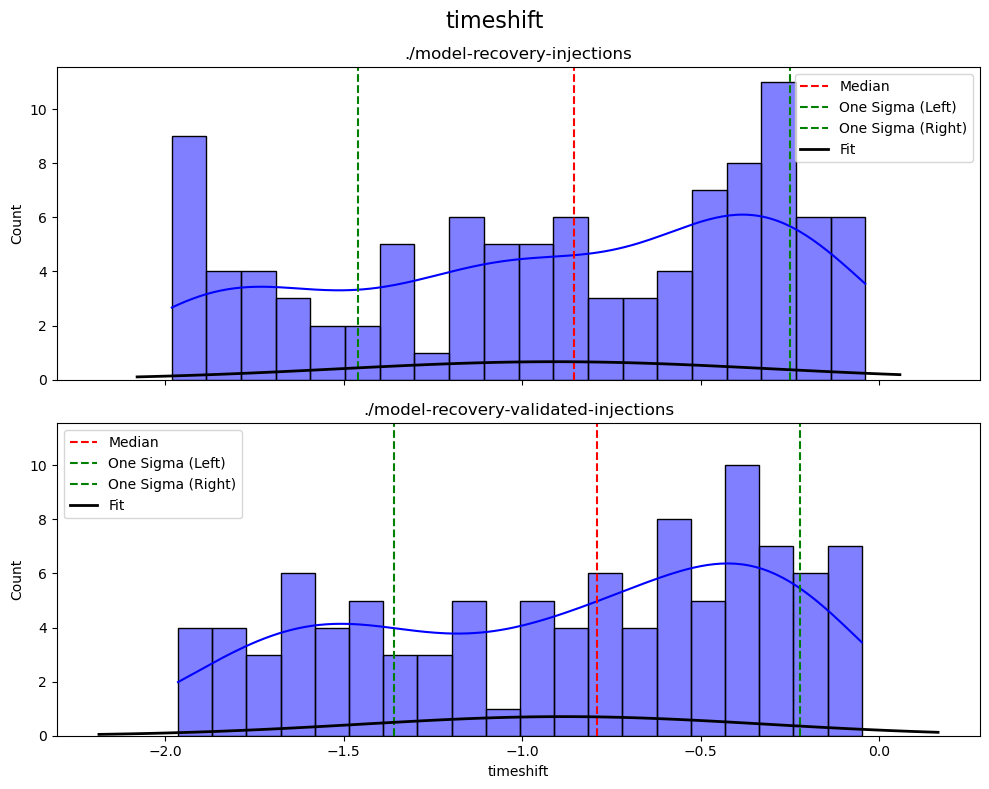

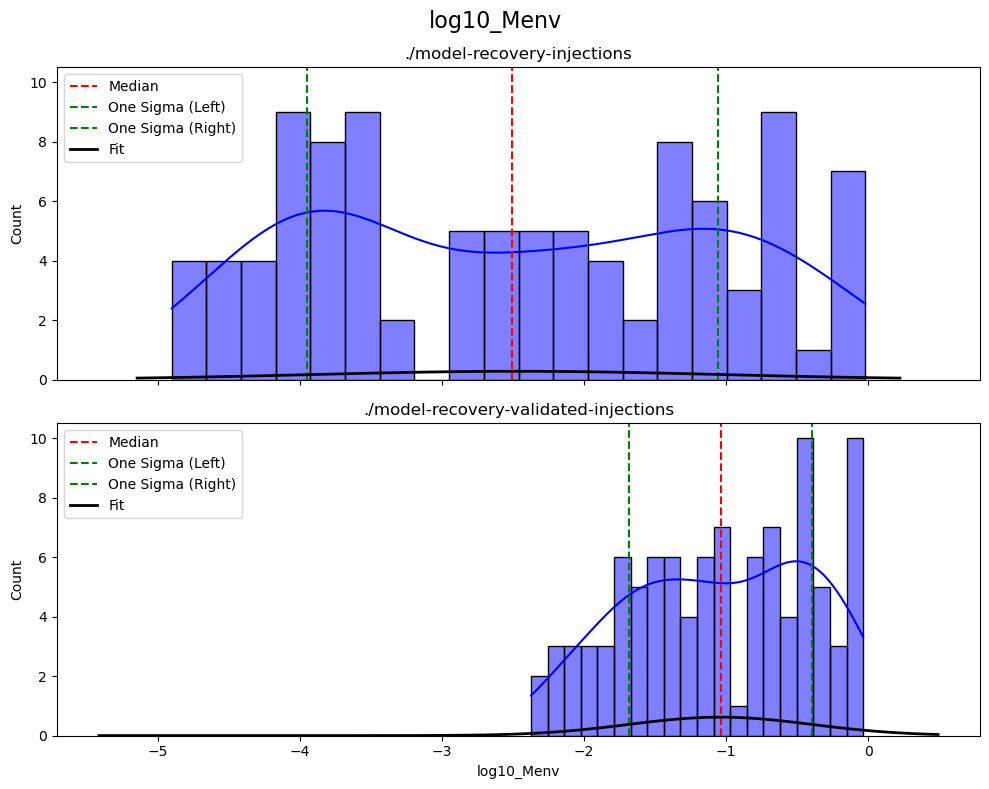

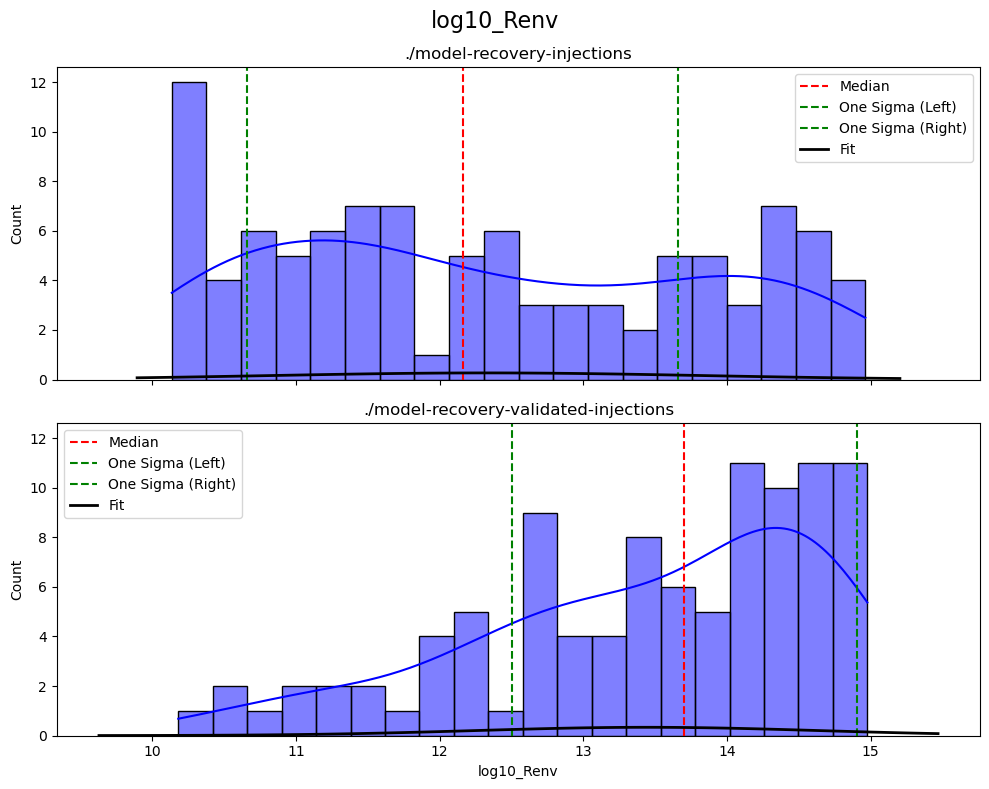

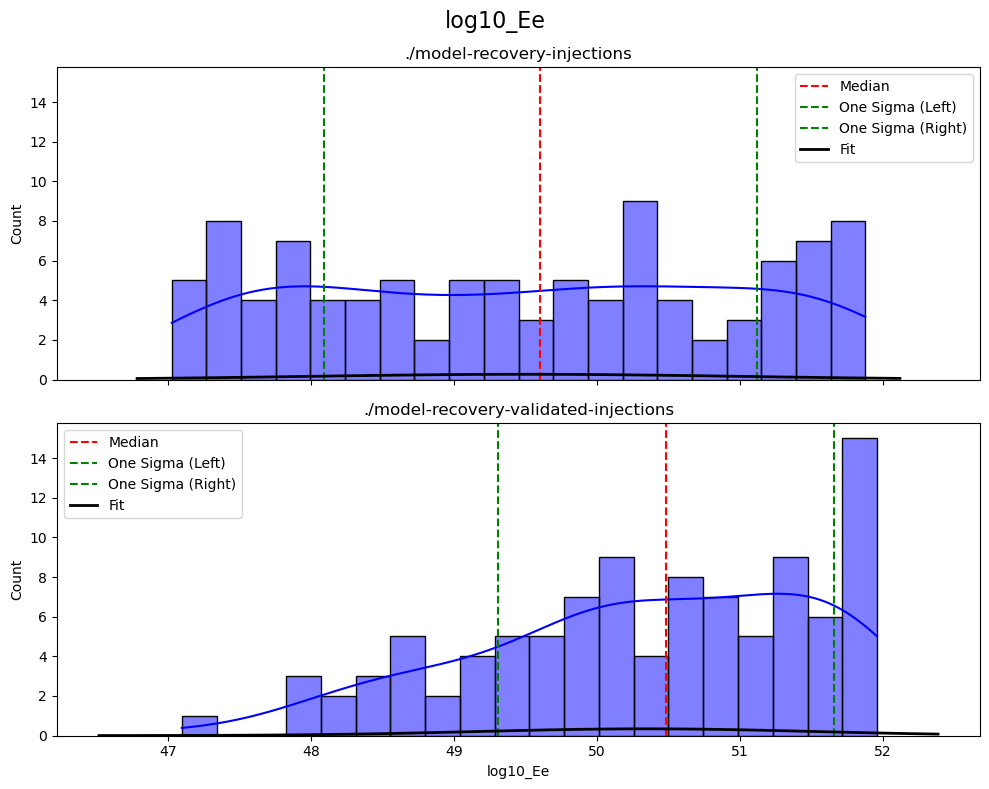

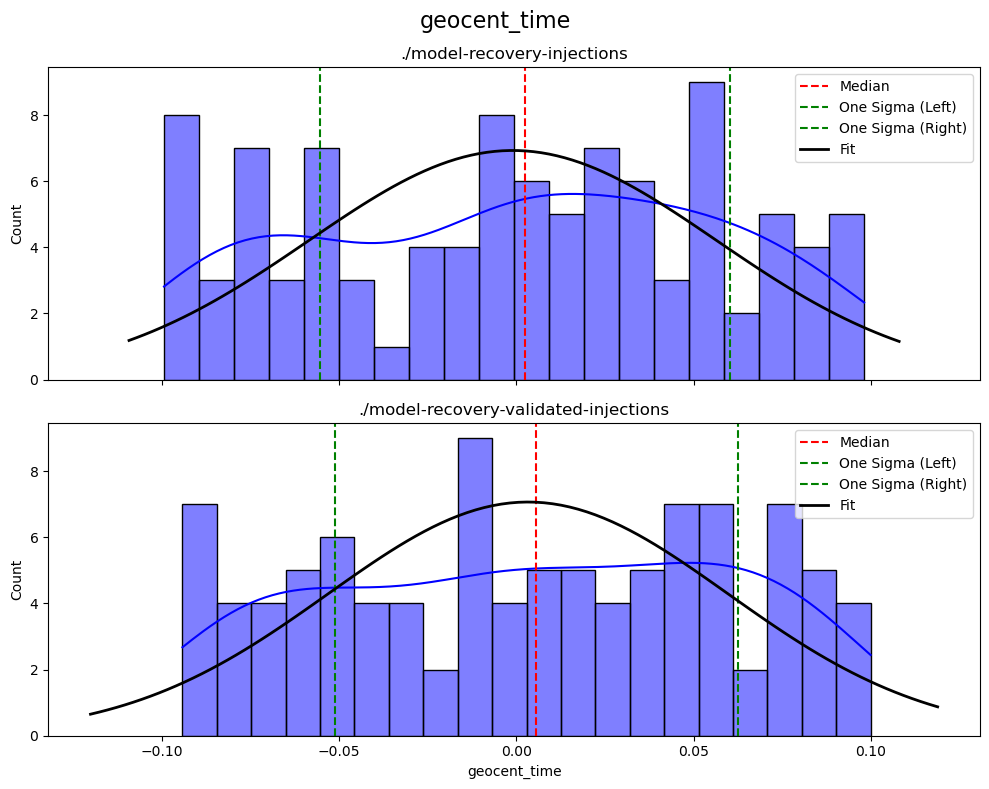

./model-recovery-injections


,simulation_id,luminosity_distance,timeshift,log10_Menv,log10_Renv,log10_Ee,geocent_time
count,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.0,550.024986,-0.907940,-2.469349,12.327747,49.494366,-0.001003
std,0.0,278.686098,0.605534,1.446114,1.501092,1.513294,0.057830
min,0.0,4.391608,-1.981582,-4.903670,10.135273,47.025905,-0.099350
25%,0.0,343.550382,-1.358194,-3.721763,11.032799,48.060268,-0.053703
50%,0.0,599.140164,-0.854599,-2.505453,12.159882,49.604420,0.002554
75%,0.0,753.583916,-0.359898,-1.196292,13.735125,50.732013,0.047572
max,0.0,999.794122,-0.039399,-0.021172,14.962028,51.875823,0.098098


./model-recovery-validated-injections


,simulation_id,luminosity_distance,timeshift,log10_Menv,log10_Renv,log10_Ee,geocent_time
count,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.0,371.298581,-0.883625,-1.042168,13.443676,50.347347,0.003319
std,0.0,307.090600,0.567445,0.646761,1.198998,1.175762,0.056715
min,0.0,1.591787,-1.964117,-2.374556,10.180605,47.095720,-0.094157
25%,0.0,102.328786,-1.438143,-1.556986,12.734048,49.614564,-0.047031
50%,0.0,268.966014,-0.790567,-1.039898,13.702802,50.484384,0.005687
75%,0.0,615.346566,-0.384377,-0.467966,14.445724,51.314714,0.051395
max,0.0,995.767921,-0.049051,-0.035902,14.976762,51.958327,0.099924


In [44]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the folder paths
folder_paths = ['./model-recovery-injections', './model-recovery-validated-injections']

# Initialize an empty list to store DataFrames
dfs = []

# Load DataFrames from the specified folders
for folder_path in folder_paths:
    data_list = []
    for filename in os.listdir(folder_path):
        if filename.startswith("inj_Piro2021_") and filename.endswith(".json"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as file:
                json_data = json.load(file)
            content = json_data['injections']['content']
            for key, value in content.items():
                if len(value) == 1:
                    content[key] = value[0]
            data_list.append(content)
    df = pd.DataFrame(data_list)
    dfs.append(df)

# Create histograms for each column in both DataFrames
for i, column in enumerate(dfs[0].columns):
    if column.startswith('simulation_id'):
        continue
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True, sharey=True)
    fig.suptitle(column, fontsize=16)
    
    for j, df in enumerate(dfs):
        ax = axes[j]
        sns.histplot(df[column], kde=True, color='blue', bins=20, ax=ax)
        
        median = df[column].median()
        std = df[column].std()
        
        ax.axvline(median, color='red', linestyle='--', label='Median')
        ax.axvline(median - std, color='green', linestyle='--', label='One Sigma (Left)')
        ax.axvline(median + std, color='green', linestyle='--', label='One Sigma (Right)')
        
        mu, std = norm.fit(df[column])
        
        xmin, xmax = ax.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        
        ax.plot(x, p, 'k', linewidth=2, label='Fit')
        
        #ax.set_xlabel(f'{folder_paths[j]} - {column}')
        ax.set_title(f'{folder_paths[j]}')
        ax.legend()
    
    # Adjust the layout
    plt.tight_layout()

# Show the plots
plt.show()


for i, df in enumerate(dfs):
    print(folder_paths[i])
    display(df.describe())

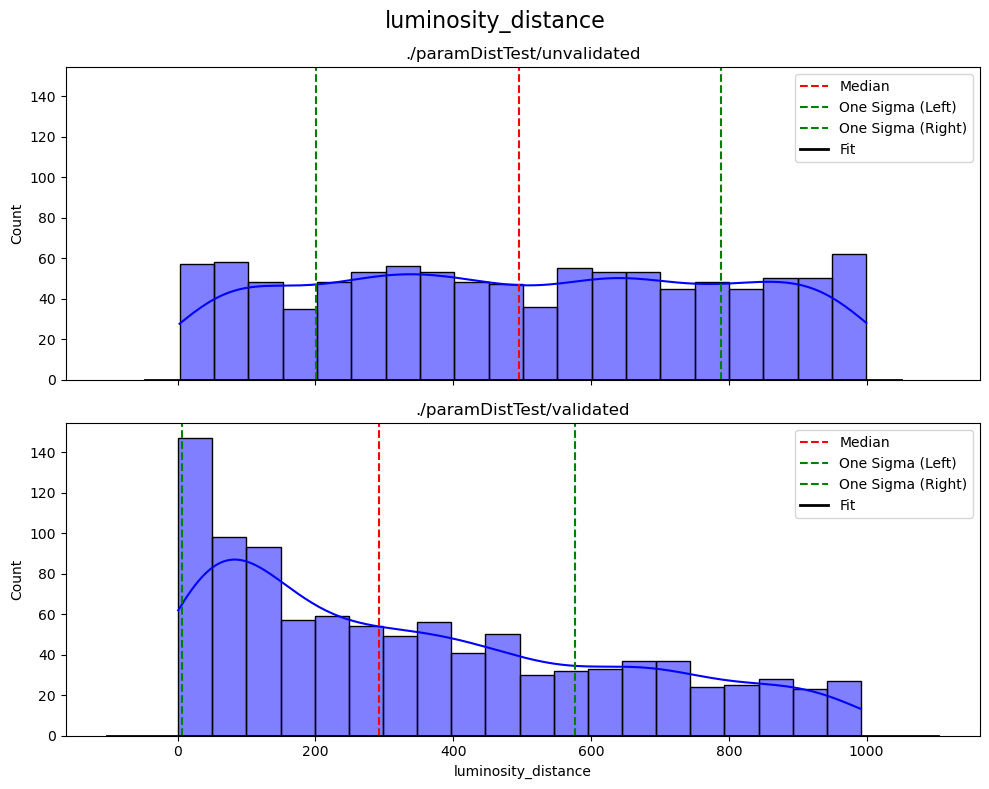

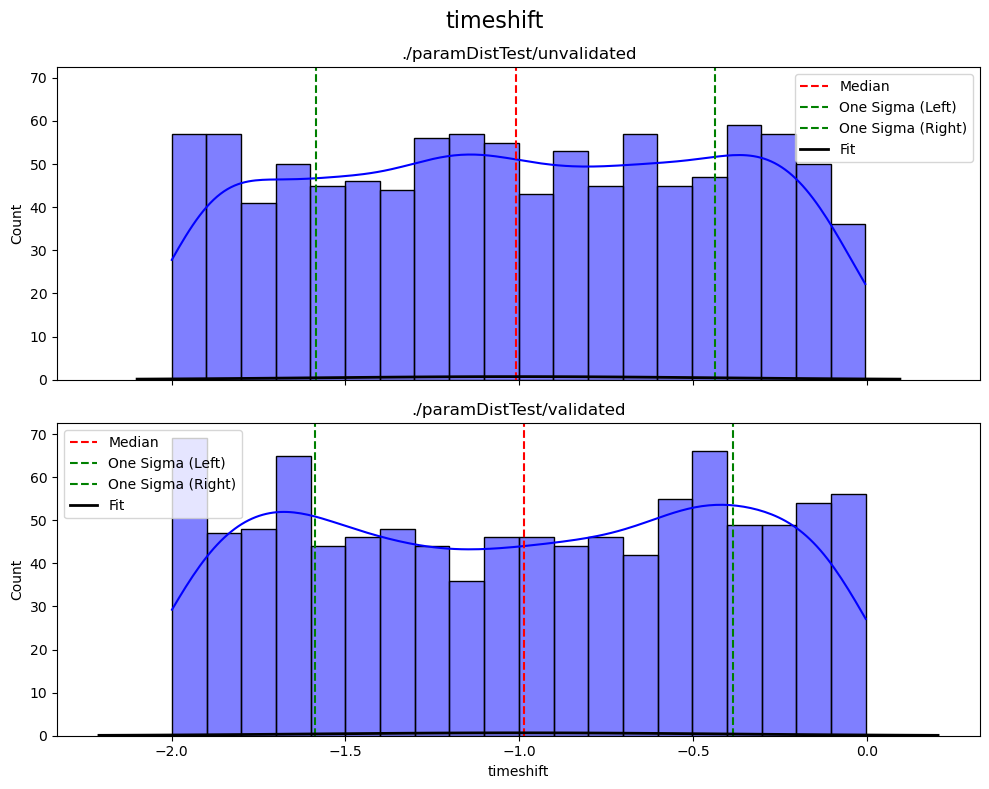

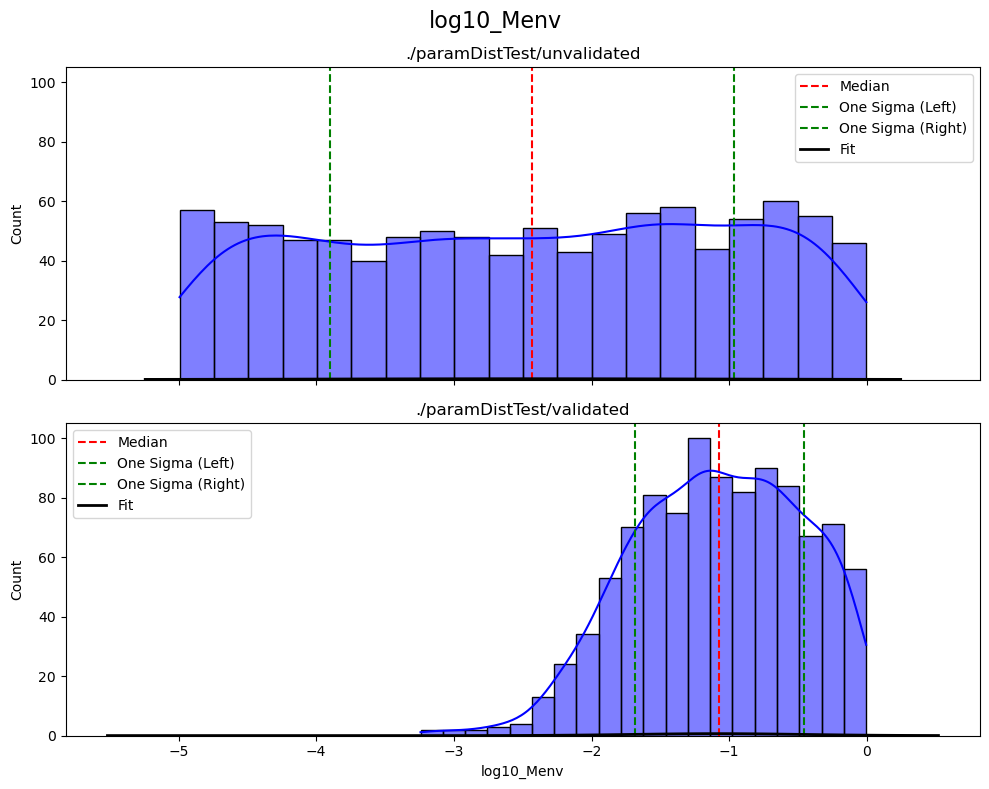

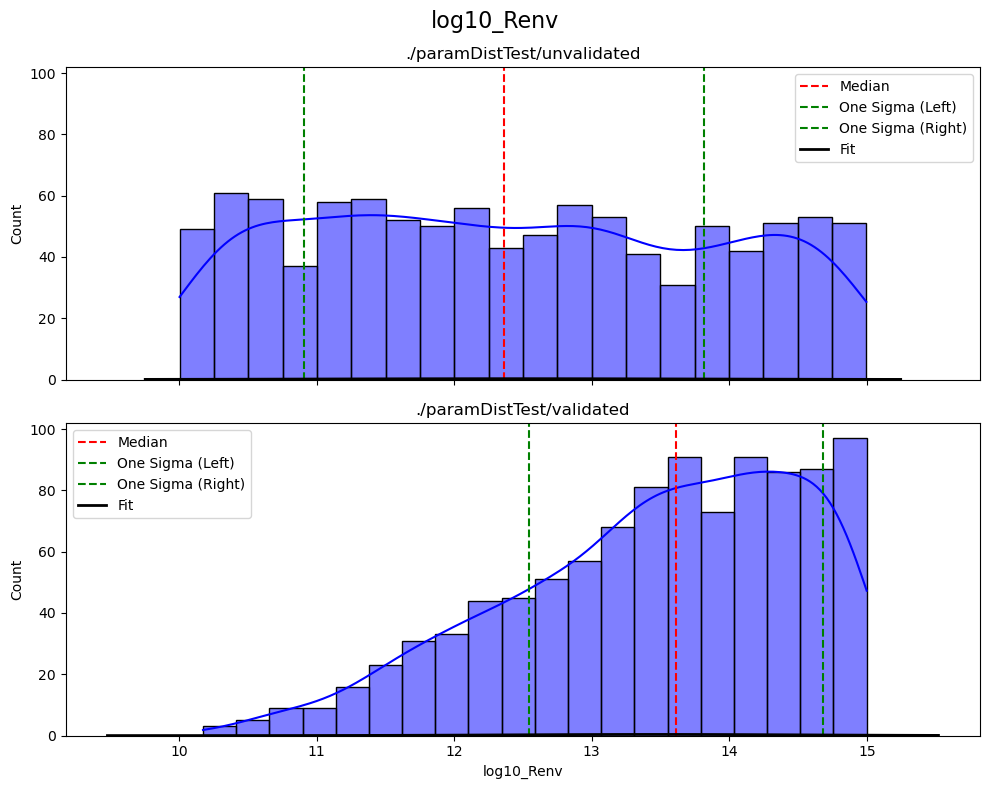

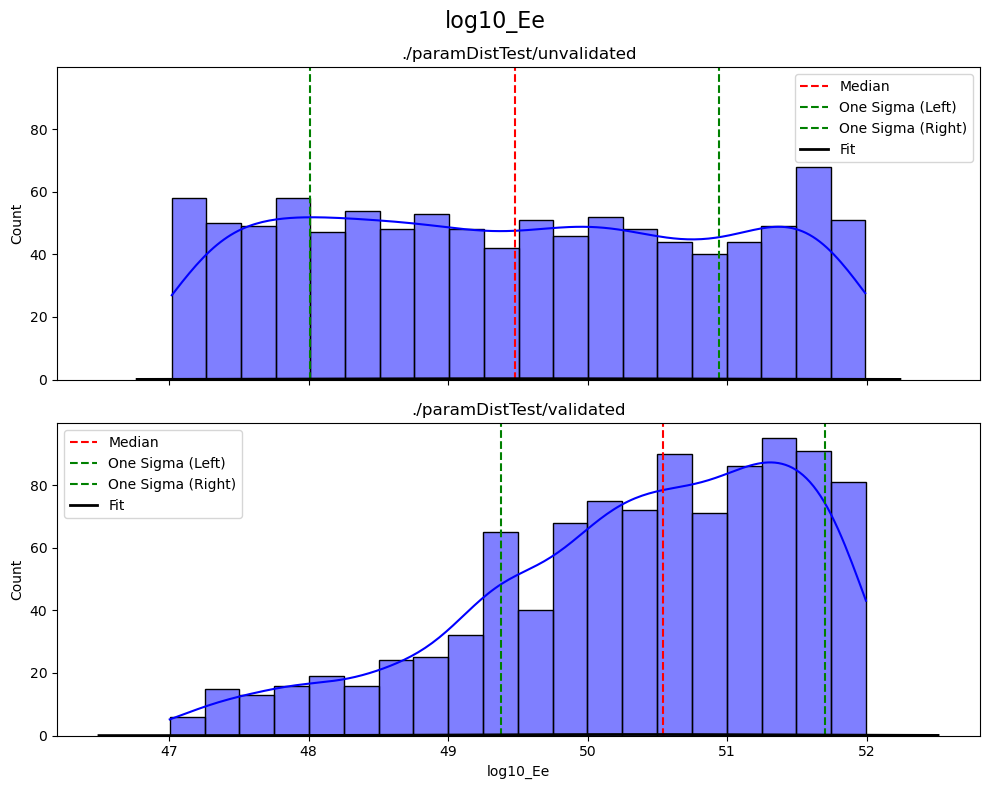

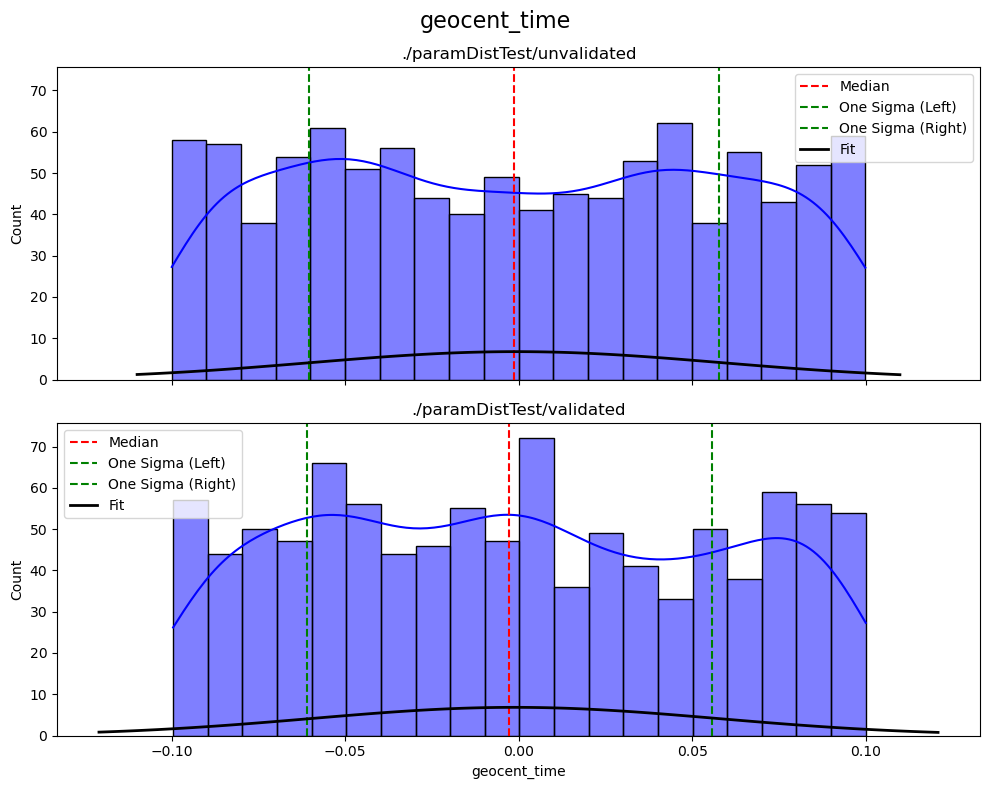

./paramDistTest/unvalidated


,simulation_id,luminosity_distance,timeshift,log10_Menv,log10_Renv,log10_Ee,geocent_time
count,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.0,501.932698,-1.008517,-2.474463,12.430318,49.482045,-0.000797
std,0.0,293.768573,0.574820,1.470843,1.454168,1.467247,0.059069
min,0.0,2.703534,-1.999172,-4.992974,10.002913,47.020371,-0.099958
25%,0.0,255.740752,-1.501171,-3.796972,11.168938,48.177443,-0.052633
50%,0.0,495.001012,-1.010793,-2.432807,12.359386,49.477050,-0.001384
75%,0.0,756.642150,-0.505555,-1.210565,13.705473,50.760109,0.048831
max,0.0,999.581978,-0.005370,-0.003601,14.996290,51.988888,0.099784


./paramDistTest/validated


,simulation_id,luminosity_distance,timeshift,log10_Menv,log10_Renv,log10_Ee,geocent_time
count,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.0,353.505119,-1.002106,-1.084190,13.459499,50.344238,-0.001229
std,0.0,284.971355,0.600681,0.614896,1.067816,1.161035,0.058381
min,0.0,0.743602,-1.998660,-3.242406,10.173281,47.005584,-0.099573
25%,0.0,102.137658,-1.552147,-1.531028,12.750252,49.576436,-0.051968
50%,0.0,291.821274,-0.987661,-1.072638,13.614725,50.538305,-0.002768
75%,0.0,569.393374,-0.469603,-0.598161,14.311434,51.277584,0.050749
max,0.0,991.932192,-0.003899,-0.005068,14.998754,51.994246,0.099926


In [45]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the folder paths
folder_paths = ['./paramDistTest/unvalidated', './paramDistTest/validated']

# Initialize an empty list to store DataFrames
dfs = []

# Load DataFrames from the specified folders
for folder_path in folder_paths:
    data_list = []
    for filename in os.listdir(folder_path):
        if filename.startswith("inj_Piro2021_") and filename.endswith(".json"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as file:
                json_data = json.load(file)
            content = json_data['injections']['content']
            for key, value in content.items():
                if len(value) == 1:
                    content[key] = value[0]
            data_list.append(content)
    df = pd.DataFrame(data_list)
    dfs.append(df)

# Create histograms for each column in both DataFrames
for i, column in enumerate(dfs[0].columns):
    if column.startswith('simulation_id'):
        continue
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True, sharey=True)
    fig.suptitle(column, fontsize=16)
    
    for j, df in enumerate(dfs):
        ax = axes[j]
        sns.histplot(df[column], kde=True, color='blue', bins=20, ax=ax)
        
        median = df[column].median()
        std = df[column].std()
        
        ax.axvline(median, color='red', linestyle='--', label='Median')
        ax.axvline(median - std, color='green', linestyle='--', label='One Sigma (Left)')
        ax.axvline(median + std, color='green', linestyle='--', label='One Sigma (Right)')
        
        mu, std = norm.fit(df[column])
        
        xmin, xmax = ax.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        
        ax.plot(x, p, 'k', linewidth=2, label='Fit')
        
        #ax.set_xlabel(f'{folder_paths[j]} - {column}')
        ax.set_title(f'{folder_paths[j]}')
        ax.legend()
    
    # Adjust the layout
    plt.tight_layout()

# Show the plots
plt.show()


for i, df in enumerate(dfs):
    print(folder_paths[i])
    display(df.describe())